In [65]:
import os

import numpy as np

#run_id = '2017-05-09T22:29:39.085735'
#run_id = '2017-05-10T15:56:45.442836'
#run_id = '2017-05-10T16:10:08.506840'
#run_id = '2017-05-10T23:14:30.920993'
run_id = '2017-05-11T00:09:45.179689'

import htsohm
from htsohm.files import load_config_file

htsohm_dir = os.path.dirname(os.path.dirname(htsohm.__file__))
config_file = os.path.join(htsohm_dir, run_id, 'config.yaml')
config = load_config_file(config_file)

nd_limits       = config['number_density_limits']
sigma_limits    = config['sigma_limits']
epsilon_limits  = config['epsilon_limits']

nd = np.arange(*nd_limits, 0.0001)

from htsohm.pseudo_simulation import pseudo_void_fraction, pseudo_surface_area, pseudo_gas_adsorption

vf_ = [pseudo_void_fraction(config, i, sigma_limits[1]) for i in nd]

sa_0 = [pseudo_surface_area(i, sigma_limits[0]) for i in vf_]
sa_1 = [pseudo_surface_area(i, sigma_limits[1]) for i in vf_]

ga_0 = [pseudo_gas_adsorption(config, vf_[i], sa_1[i], epsilon_limits[0]) for i in range(len(vf_))]
ga_1 = [pseudo_gas_adsorption(config, vf_[i], sa_1[i], epsilon_limits[1]) for i in range(len(vf_))]

In [66]:
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
import os

import htsohm
from htsohm.db.__init__ import session, Material
from htsohm.files import load_config_file

number_of_points = 1000

htsohm_path = os.path.dirname(os.path.dirname(htsohm.__file__))
config_path = os.path.join(htsohm_path, run_id, 'config.yaml')
config = load_config_file(config_path)

ga_data = [e[0] for e in session.query(Material.ga0_absolute_volumetric_loading) \
           .filter(Material.run_id == run_id).all()]
sa_data = [e[0] for e in session.query(Material.sa_volumetric_surface_area) \
           .filter(Material.run_id == run_id).all()]
vf_data = [e[0] for e in session.query(Material.vf_helium_void_fraction) \
           .filter(Material.run_id == run_id).all()]

indices = range(len(ga_data))[0::int(len(ga_data) / number_of_points)]

ga_data = [ga_data[i] for i in indices]
sa_data = [sa_data[i] for i in indices]
vf_data = [vf_data[i] for i in indices]

print('GA points :\t{}'.format(len(ga_data)))
print('SA points :\t{}'.format(len(sa_data)))
print('VF points :\t{}'.format(len(vf_data)))

GA points :	1016
SA points :	1016
VF points :	1016


In [68]:
uuids = [e[0] for e in session.query(Material.uuid).filter(Material.run_id == run_id).all()]

uuids = [uuids[i] for i in indices]

from IPython.display import clear_output
import yaml

number_densities = []
average_sigmas = []
average_epsilons = []

#ga_data_2 = []
#sa_data_2 = []
#vf_data_2 = []

pseudo_materials_path = os.path.join(htsohm_path, run_id, 'pseudo_materials')
counter = 1
for uuid in uuids:
    clear_output()
    print('{} / {} ...'.format(counter, len(uuids)))
    pseudo_material_path = os.path.join(pseudo_materials_path, '{}.yaml'.format(uuid))
    with open(pseudo_material_path) as pseudo_material_file:
        pseudo_material = yaml.load(pseudo_material_file)

    number_densities.append(pseudo_material.number_density())
    average_sigmas.append(pseudo_material.average_sigma())
    average_epsilons.append(pseudo_material.average_epsilon())
    
    counter += 1

#    ga_data_2.append(pseudo_material.artificial_gas_adsorption())
#    sa_data_2.append(pseudo_material.artificial_surface_area())
#    vf_data_2.append(pseudo_material.artificial_void_fraction())

print('...done!')

1016 / 1016 ...
...done!


In [69]:
print('number density limits :\t\t\t{}\t\t{}'.format(*nd_limits))
print('observed number densities :\t\t{}\t{}'.format(min(number_densities), max(number_densities)))

print('\nsigma limits :\t\t\t\t{}\t\t\t{}'.format(*sigma_limits))
print('observed average sigmas :\t\t{}\t{}'.format(min(average_sigmas), max(average_sigmas)))

print('\nepsilon limits :\t\t\t{}\t\t\t{}'.format(*epsilon_limits))
print('observed average epsilons :\t\t{}\t{}'.format(min(average_epsilons), max(average_epsilons)))

number density limits :			1.49e-05		0.02122
observed number densities :		0.0020717809486196447	0.020803223414956537

sigma limits :				1.052			6.549
observed average sigmas :		1.5737208067162338	5.740914901966174

epsilon limits :			1.258			513.264
observed average epsilons :		135.34609616343903	391.59003657152573


In [70]:
nd_obs = np.arange(min(number_densities), max(number_densities), 0.001)

vf_obs = [pseudo_void_fraction(config, i, max(average_sigmas)) for i in nd_obs]

sa_obs_0 = [pseudo_surface_area(i, min(average_sigmas)) for i in vf_obs]
sa_obs_1 = [pseudo_surface_area(i, max(average_sigmas)) for i in vf_obs]

ga_obs_0 = [pseudo_gas_adsorption(config, vf_obs[i], sa_obs_1[i], min(average_epsilons)) for i in range(len(vf_obs))]
ga_obs_1 = [pseudo_gas_adsorption(config, vf_obs[i], sa_obs_1[i], max(average_epsilons)) for i in range(len(vf_obs))]

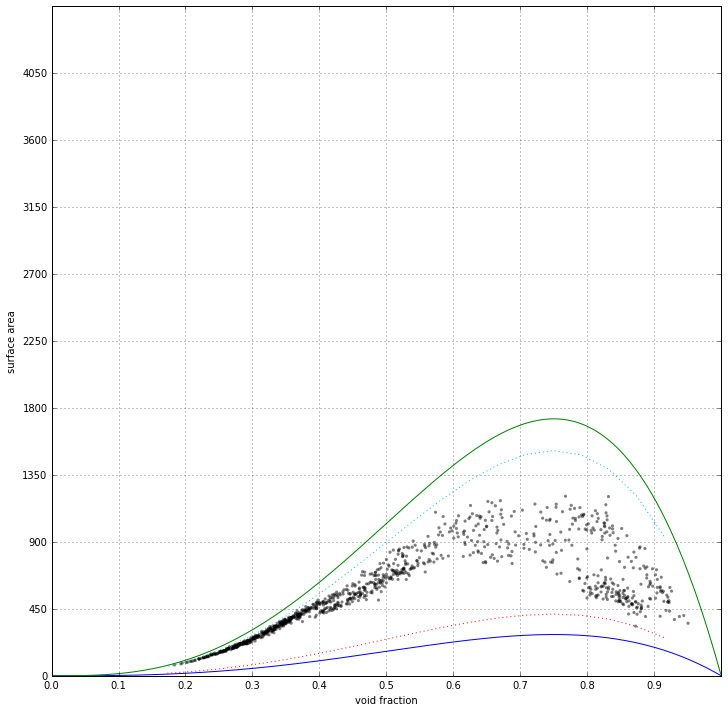

In [71]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
ax.set_xticks(np.arange(
    *config['helium_void_fraction']['limits'],
    (config['helium_void_fraction']['limits'][1] - config['helium_void_fraction']['limits'][0]) / config['number_of_convergence_bins']
))
ax.set_yticks(np.arange(
    *config['surface_area']['limits'],
    (config['surface_area']['limits'][1] - config['surface_area']['limits'][0]) / config['number_of_convergence_bins']
))
plt.grid()

plt.scatter(vf_data, sa_data, edgecolor='none', facecolor='k', alpha=0.5, s=10)
#plt.scatter(vf_data_2, sa_data_2, edgecolor='none', facecolor='b', alpha=0.5, s=10)
plt.plot(vf_, sa_0)
plt.plot(vf_, sa_1)

plt.plot(vf_obs, sa_obs_0, ':')
plt.plot(vf_obs, sa_obs_1, ':')

plt.xlim(*config['helium_void_fraction']['limits'])
plt.ylim(*config['surface_area']['limits'])
#plt.xlim(min(vf_), max(vf_))
#plt.ylim(min(sa_0 + sa_1), max(sa_0 + sa_1))

plt.xlabel('void fraction')
plt.ylabel('surface area')

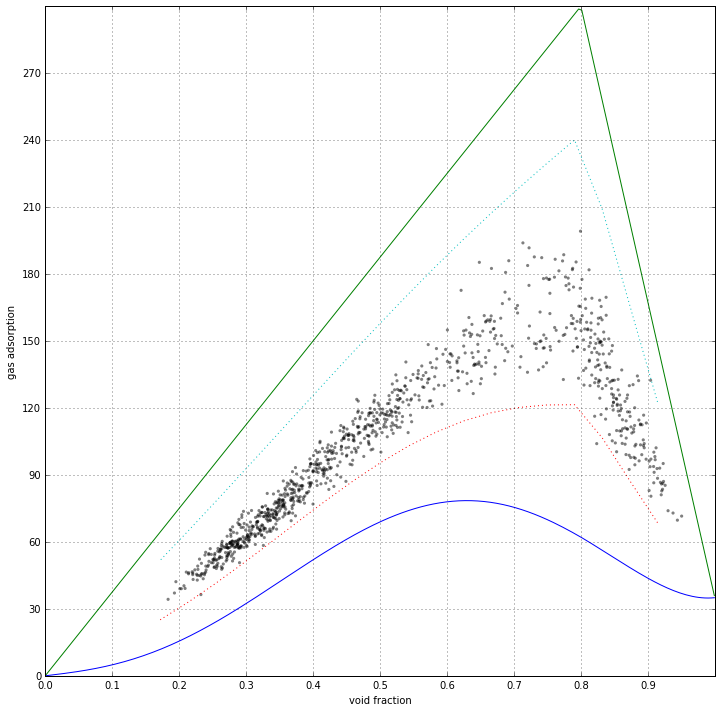

In [72]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
ax.set_xticks(np.arange(
    *config['helium_void_fraction']['limits'],
    (config['helium_void_fraction']['limits'][1] - config['helium_void_fraction']['limits'][0]) / config['number_of_convergence_bins']
))
ax.set_yticks(np.arange(
    *config['gas_adsorption_0']['limits'],
    (config['gas_adsorption_0']['limits'][1] - config['gas_adsorption_0']['limits'][0]) / config['number_of_convergence_bins']
))
plt.grid()

plt.scatter(vf_data, ga_data, edgecolor='none', facecolor='k', alpha=0.5, s=10)
#plt.scatter(vf_data_2, ga_data_2, edgecolor='none', facecolor='b', alpha=0.5, s=10)
plt.plot(vf_, ga_0)
plt.plot(vf_, ga_1)

plt.plot(vf_obs, ga_obs_0, ':')
plt.plot(vf_obs, ga_obs_1, ':')

plt.xlabel('void fraction')
plt.ylabel('gas adsorption')

#plt.xlim(min(vf_), max(vf_))
#plt.ylim(min(ga_0 + ga_1), max(ga_0 + ga_1))
plt.xlim(*config['helium_void_fraction']['limits'])
plt.ylim(*config['gas_adsorption_0']['limits'])

plt.show()

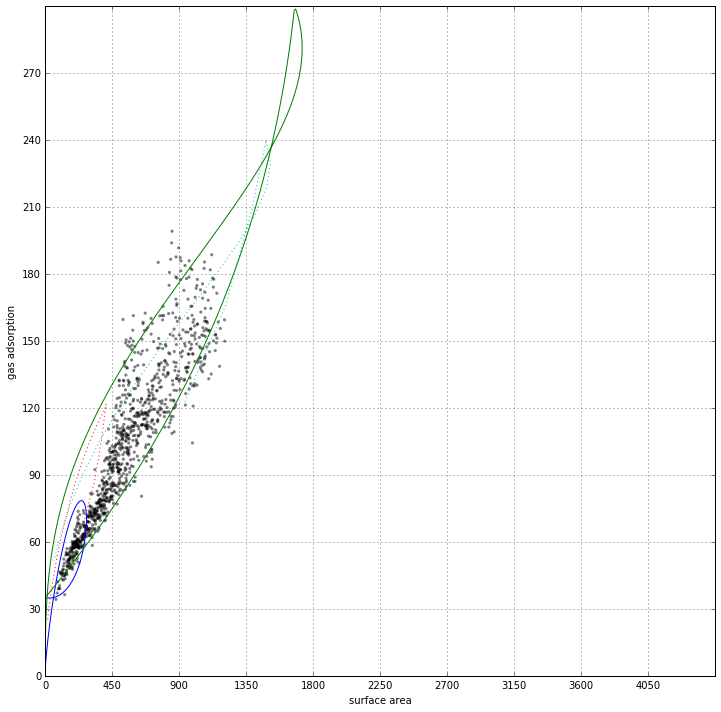

In [73]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
ax.set_xticks(np.arange(
    *config['surface_area']['limits'],
    (config['surface_area']['limits'][1] - config['surface_area']['limits'][0]) / config['number_of_convergence_bins']
))
ax.set_yticks(np.arange(
    *config['gas_adsorption_0']['limits'],
    (config['gas_adsorption_0']['limits'][1] - config['gas_adsorption_0']['limits'][0]) / config['number_of_convergence_bins']
))
plt.grid()

plt.scatter(sa_data, ga_data, edgecolor='none', facecolor='k', alpha=0.5, s=10)
#plt.scatter(sa_data_2, ga_data_2, edgecolor='none', facecolor='b', alpha=0.5, s=10)
plt.plot(sa_0, ga_0)
plt.plot(sa_1, ga_1)

plt.plot(sa_obs_0, ga_obs_0, ':')
plt.plot(sa_obs_1, ga_obs_1, ':')

plt.xlabel('surface area')
plt.ylabel('gas adsorption')

#plt.xlim(min(sa_0 + sa_1), max(sa_0 + sa_1))
#plt.ylim(min(ga_0 + ga_1), max(ga_0 + ga_1))
plt.xlim(*config['surface_area']['limits'])
plt.ylim(*config['gas_adsorption_0']['limits'])

plt.show()

In [55]:
vf_ = [pseudo_void_fraction(config, i, sigma_limits[1]) for i in nd]

sigmas = np.arange(sigma_limits[0], sigma_limits[1] + (sigma_limits[1] - sigma_limits[0]) / 4, (sigma_limits[1] - sigma_limits[0]) / 4)
epsilons = np.arange(epsilon_limits[0], epsilon_limits[1] + (epsilon_limits[1] - epsilon_limits[0]) / 4, (epsilon_limits[1] - epsilon_limits[0]) / 4)               

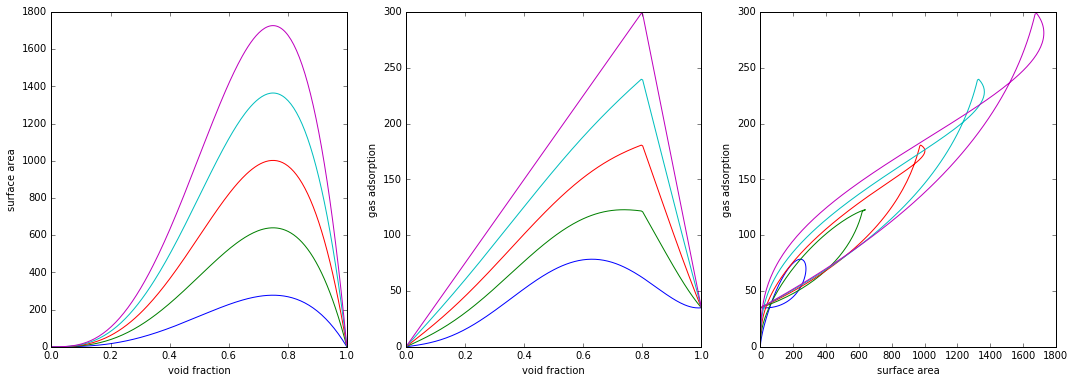

In [64]:
sa_0 = [pseudo_surface_area(i, sigmas[0]) for i in vf_]
sa_1 = [pseudo_surface_area(i, sigmas[1]) for i in vf_]
sa_2 = [pseudo_surface_area(i, sigmas[2]) for i in vf_]
sa_3 = [pseudo_surface_area(i, sigmas[3]) for i in vf_]
sa_4 = [pseudo_surface_area(i, sigmas[4]) for i in vf_]

ga_0 = [pseudo_gas_adsorption(config, vf_[i], sa_4[i], epsilons[0]) for i in range(len(vf_))]
ga_1 = [pseudo_gas_adsorption(config, vf_[i], sa_4[i], epsilons[1]) for i in range(len(vf_))]
ga_2 = [pseudo_gas_adsorption(config, vf_[i], sa_4[i], epsilons[2]) for i in range(len(vf_))]
ga_3 = [pseudo_gas_adsorption(config, vf_[i], sa_4[i], epsilons[3]) for i in range(len(vf_))]
ga_4 = [pseudo_gas_adsorption(config, vf_[i], sa_4[i], epsilons[4]) for i in range(len(vf_))]

#plt.subplot(131)
f, axs = plt.subplots(1,3,figsize=(18,6))

plt.subplot(131)
plt.plot(vf_, sa_0)
plt.plot(vf_, sa_1)
plt.plot(vf_, sa_2)
plt.plot(vf_, sa_3)
plt.plot(vf_, sa_4)
plt.xlabel('void fraction')
plt.ylabel('surface area')

plt.subplot(132)
plt.plot(vf_, ga_0)
plt.plot(vf_, ga_1)
plt.plot(vf_, ga_2)
plt.plot(vf_, ga_3)
plt.plot(vf_, ga_4)
plt.xlabel('void fraction')
plt.ylabel('gas adsorption')

plt.subplot(133)
plt.plot(sa_0, ga_0)
plt.plot(sa_1, ga_1)
plt.plot(sa_2, ga_2)
plt.plot(sa_3, ga_3)
plt.plot(sa_4, ga_4)
plt.xlabel('surface area')
plt.ylabel('gas adsorption')